In [33]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime

def extrair_dados_financeiros(ticker_symbol, start_date, end_date):
    ticker = yf.Ticker(ticker_symbol)
    
    dados = {
        'Preço': yf.download(tickers=ticker_symbol, start=start_date, end=end_date),
        'Info': ticker.info,
        'Dividendos': ticker.dividends,
        'Splits': ticker.splits,
        'Financeiros': {
            'Balanço': ticker.balance_sheet,
            'DRE': ticker.financials,
            'Fluxo_Caixa': ticker.cashflow
        },
        'Sustentabilidade': ticker.sustainability,
        'Recomendações': ticker.recommendations,
        'Calendário': ticker.calendar
    }
    
    return dados

def calcular_indicadores_completos(dados):
    
    indicadores = pd.DataFrame()

    if 'DRE' in dados['Financeiros']:
        dre = dados['Financeiros']['DRE']
        if not dre.empty:
            indicadores['LPA'] = dre.loc['Net Income'] / dados['Info'].get('sharesOutstanding', 1)
            
            indicadores['Margem_Liquida'] = dre.loc['Net Income'] / dre.loc['Total Revenue']
            
            if 'EBITDA' in dre.index:
                indicadores['Margem_EBITDA'] = dre.loc['EBITDA'] / dre.loc['Total Revenue']
    
    if not dados['Dividendos'].empty:
        indicadores['Dividend_Yield'] = dados['Dividendos'].groupby(dados['Dividendos'].index.year).sum() / dados['Preço']['Close'].groupby(dados['Preço'].index.year).mean()
    
    return indicadores

ticker_symbol = "BEEF3.SA"
start_date = "2020-01-01"
end_date = "2023-12-31"

dados = extrair_dados_financeiros(ticker_symbol, start_date, end_date)

indicadores = calcular_indicadores_completos(dados)

print("\nIndicadores de Mercado:")
print(indicadores)

print("\nInformações Disponíveis:")
for key in dados.keys():
    print(f"- {key}")

[*********************100%%**********************]  1 of 1 completed
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/BEEF3.SA?modules=esgScores&corsDomain=finance.yahoo.com&formatted=false&symbol=BEEF3.SA&crumb=oXMocjyfnII



Indicadores de Mercado:
                 LPA Margem_Liquida Margem_EBITDA  Dividend_Yield
2023-12-31  0.715681       0.015657        0.0924             NaN
2022-12-31  1.109135       0.021065      0.065337             NaN
2021-12-31  1.017937       0.022209      0.072177             NaN
2020-12-31  1.184874       0.035921      0.109292             NaN

Informações Disponíveis:
- Preço
- Info
- Dividendos
- Splits
- Financeiros
- Sustentabilidade
- Recomendações
- Calendário


In [34]:
def calcular_patrimonio_liquido_medio(dados):
    balanco = dados['Financeiros']['Balanço']
    
    patrimonio_liquido = balanco.loc['Total Equity Gross Minority Interest']
    
    pl_medio = pd.Series(index=patrimonio_liquido.index)
    
    for i in range(len(patrimonio_liquido)):
        if i == 0: 
            pl_medio.iloc[i] = patrimonio_liquido.iloc[1] 
        else:
            pl_medio.iloc[i] = patrimonio_liquido.iloc[i:i+2].mean()
    
    print("Patrimônio Líquido:")
    print(patrimonio_liquido)
    print("\nPatrimônio Líquido Médio (ajustado):")
    print(pl_medio)
    
    return pl_medio

pl_medio = calcular_patrimonio_liquido_medio(dados)

Patrimônio Líquido:
2023-12-31     659550000.0
2022-12-31    1062495000.0
2021-12-31     654131000.0
2020-12-31     840072000.0
Name: Total Equity Gross Minority Interest, dtype: object

Patrimônio Líquido Médio (ajustado):
2023-12-31    1.062495e+09
2022-12-31    8.583130e+08
2021-12-31    7.471015e+08
2020-12-31    8.400720e+08
dtype: float64


In [35]:
def calcular_indicadores_fundamentalistas(dados):
    lucro_liquido = dados['Financeiros']['DRE'].loc['Net Income']
    patrimonio_liquido = dados['Financeiros']['Balanço'].loc['Total Equity Gross Minority Interest']
    total_ativos = dados['Financeiros']['Balanço'].loc['Total Assets']
    num_acoes = dados['Financeiros']['Balanço'].loc['Ordinary Shares Number']
    receita_total = dados['Financeiros']['DRE'].loc['Total Revenue']
    precos_diarios = dados['Preço']['Adj Close']
    
    pl_medio = pd.Series(index=patrimonio_liquido.index)
    for i in range(len(patrimonio_liquido)):
        if i == 0:
            pl_medio.iloc[i] = patrimonio_liquido.iloc[1]
        else:
            pl_medio.iloc[i] = patrimonio_liquido.iloc[i:i+2].mean()
    
    indicadores = pd.DataFrame(index=lucro_liquido.index)
    
    indicadores['ROE'] = lucro_liquido / pl_medio
    indicadores['ROA'] = lucro_liquido / total_ativos
    indicadores['VP'] = patrimonio_liquido / num_acoes
    
    indicadores['ML'] = lucro_liquido / receita_total  
    
    precos_anuais = precos_diarios.groupby(precos_diarios.index.year).last()
    
    precos_anuais.index = pd.to_datetime(precos_anuais.index.astype(str) + '-12-31')
    precos_anuais = precos_anuais.reindex(lucro_liquido.index)
    
    print("Preços Anuais (último dia do ano):")
    print(precos_anuais)
    
    lpa = lucro_liquido / num_acoes  
    indicadores['P/L'] = precos_anuais / lpa 
    indicadores['P/VPA'] = precos_anuais / indicadores['VP'] 
    
    return indicadores

def criar_matriz_correlacao_diaria(dados, indicadores_fundamentalistas):
    precos_diarios = dados['Preço']['Adj Close']
    
    indicadores_diarios = pd.DataFrame(index=precos_diarios.index)
    
    for coluna in ['ROE', 'ROA', 'VP', 'ML', 'P/L', 'P/VPA']:
        indicadores_diarios[coluna] = indicadores_fundamentalistas[coluna].reindex(
            precos_diarios.index, method='ffill'
        )
    
    dados_combinados = pd.DataFrame({
        'Preço': precos_diarios,
        **{col: indicadores_diarios[col] for col in indicadores_diarios.columns}
    })
    
    matriz_correlacao = dados_combinados.corr()
    
    return dados_combinados, matriz_correlacao

indicadores_fundamentalistas = calcular_indicadores_fundamentalistas(dados)
print("\nIndicadores Fundamentalistas:")
print(indicadores_fundamentalistas)

Preços Anuais (último dia do ano):
2023-12-31     7.470000
2022-12-31    12.221814
2021-12-31     9.593391
2020-12-31     8.265167
Name: Adj Close, dtype: float64

Indicadores Fundamentalistas:
                 ROE       ROA        VP        ML        P/L     P/VPA
2023-12-31  0.396288  0.014725  1.123976  0.015657  10.410542  6.646047
2022-12-31  0.760251  0.030492  1.816447  0.021065  10.955627  6.728416
2021-12-31  0.801603   0.02984  1.120764  0.022209   9.349401  8.559692
2020-12-31    0.8298  0.041191  1.540635  0.035921   6.465146   5.36478


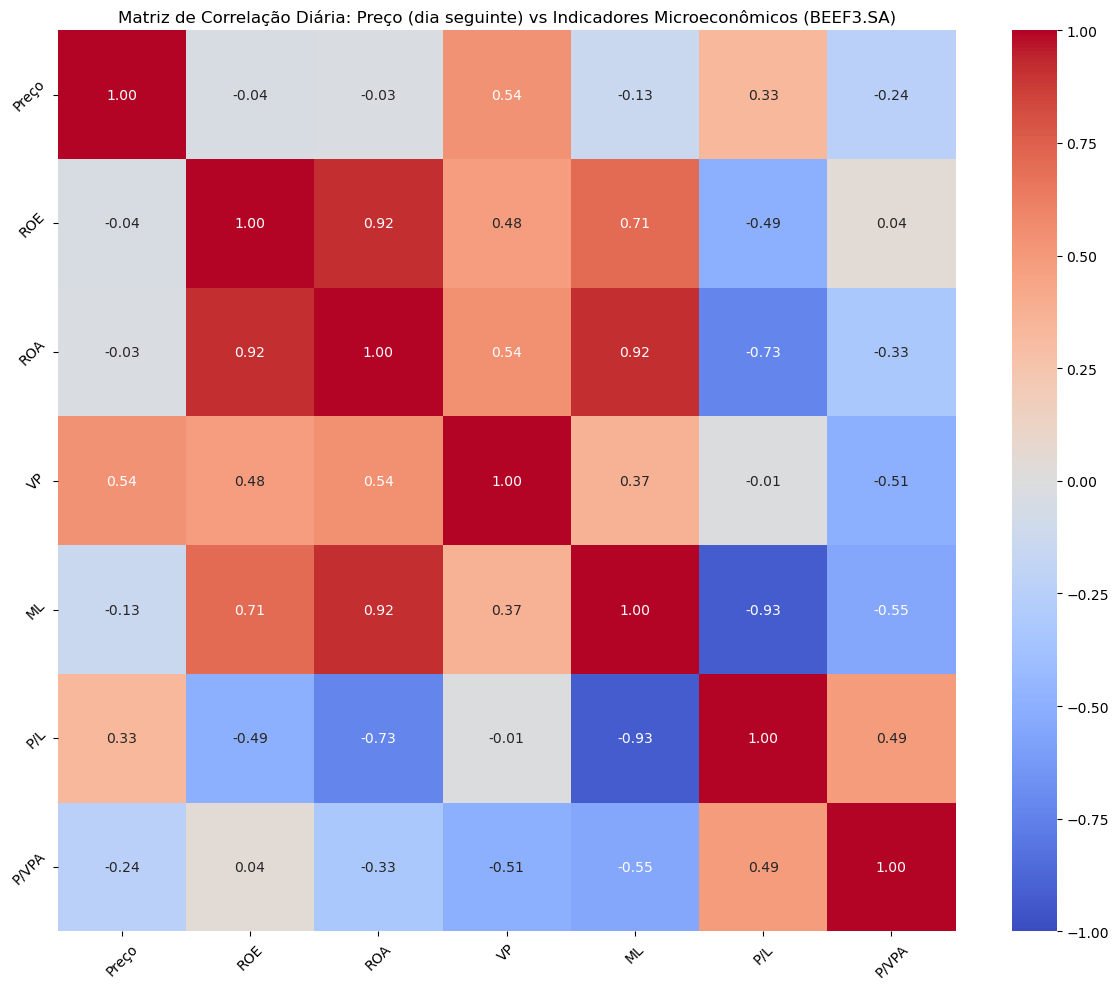


Matriz de Correlação:
          Preço       ROE       ROA        VP        ML       P/L     P/VPA
Preço  1.000000 -0.041087 -0.029748  0.535285 -0.133103  0.328658 -0.239646
ROE   -0.041087  1.000000  0.921672  0.478199  0.709153 -0.492638  0.043007
ROA   -0.029748  0.921672  1.000000  0.542878  0.918051 -0.732213 -0.325851
VP     0.535285  0.478199  0.542878  1.000000  0.367482 -0.011071 -0.506189
ML    -0.133103  0.709153  0.918051  0.367482  1.000000 -0.926978 -0.551627
P/L    0.328658 -0.492638 -0.732213 -0.011071 -0.926978  1.000000  0.490142
P/VPA -0.239646  0.043007 -0.325851 -0.506189 -0.551627  0.490142  1.000000


In [36]:
def criar_matriz_correlacao_diaria(dados, indicadores_fundamentalistas):
    precos_diarios = dados['Preço']['Adj Close']
    
    indicadores_diarios = pd.DataFrame(index=precos_diarios.index)
    
    for coluna in ['ROE', 'ROA', 'VP', 'ML', 'P/L', 'P/VPA']:
        indicadores_diarios[coluna] = indicadores_fundamentalistas[coluna].reindex(
            precos_diarios.index, method='ffill'
        )
    
    dados_combinados = pd.DataFrame({
        'Preço': precos_diarios,
        'ROE': indicadores_diarios['ROE'],
        'ROA': indicadores_diarios['ROA'],
        'VP': indicadores_diarios['VP'],
        'ML': indicadores_diarios['ML'],
        'P/L': indicadores_diarios['P/L'],
        'P/VPA': indicadores_diarios['P/VPA']
    })

    dados_combinados['Preço'] = dados_combinados['Preço'].shift(-1)

    dados_combinados.dropna(inplace=True)
    
    matriz_correlacao = dados_combinados.corr()
    
    import seaborn as sns
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(matriz_correlacao, 
                annot=True,
                fmt='.2f',
                cmap='coolwarm',
                vmin=-1, 
                vmax=1,
                center=0)
    plt.title(f'Matriz de Correlação Diária: Preço (dia seguinte) vs Indicadores Microeconômicos ({ticker_symbol})')
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    return dados_combinados, matriz_correlacao

dados_diarios, matriz_correlacao = criar_matriz_correlacao_diaria(dados, indicadores_fundamentalistas)
print("\nMatriz de Correlação:")
print(matriz_correlacao)